In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
%matplotlib inline


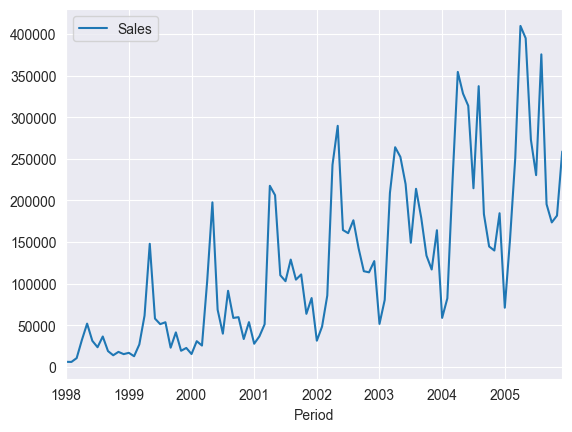

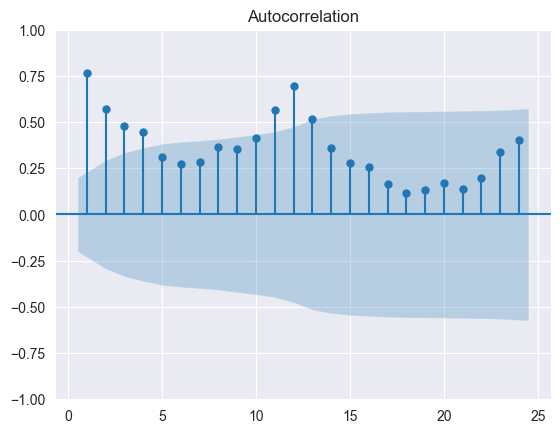

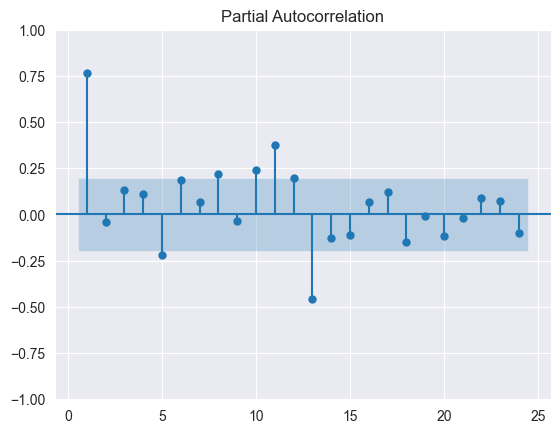

In [2]:
dataset = r".\dataset.xls"
df = pd.read_excel(dataset, parse_dates=True, index_col="Period")
sns.set_style("darkgrid")
df.plot(grid=True, subplots=True)
tsaplots.plot_acf(df["Sales"], lags=24, zero=False)
tsaplots.plot_pacf(df["Sales"], lags=24, zero=False)
plt.show()

'Seasonal Indexes:'

Period
2005-01-01    0.321058
2005-02-01    0.463488
2005-03-01    0.820929
2005-04-01    1.757131
2005-05-01    2.223672
2005-06-01    1.225877
2005-07-01    0.977907
2005-08-01    1.349063
2005-09-01    0.855764
2005-10-01    0.771658
2005-11-01    0.562030
2005-12-01    0.671423
Name: seasonal, dtype: float64

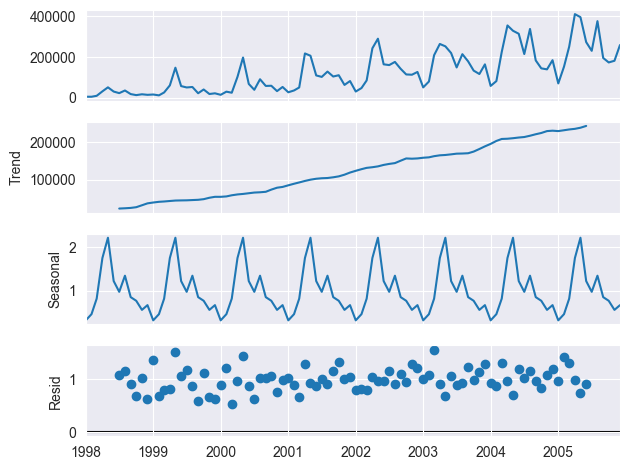

In [3]:
seasonal_decomposition = seasonal_decompose(df, model="mul",period=12)
display("Seasonal Indexes:",seasonal_decomposition.seasonal.tail(12))
seasonal_decomposition.plot()
plt.show()

In [4]:
X_train=df.loc[:"2004-12-01"]
X_test=df.loc["2005-01-01":]

In [5]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_holt_winters = ExponentialSmoothing(X_train, trend="mul", seasonal="mul",seasonal_periods=12, initialization_method="estimated").fit(optimized=True)
forecast_holt_winters = model_holt_winters.forecast(12)

c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


C:\Users\Gabriel\AppData\Local\Temp\ipykernel_1136\4076976252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Sales_diff1_diff12"] = X_train["Sales"].diff(1).diff(12)


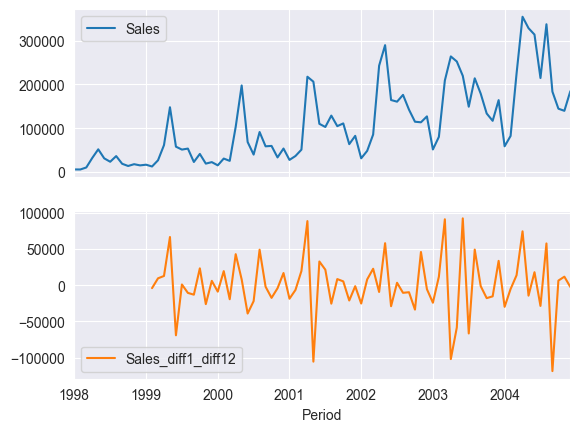

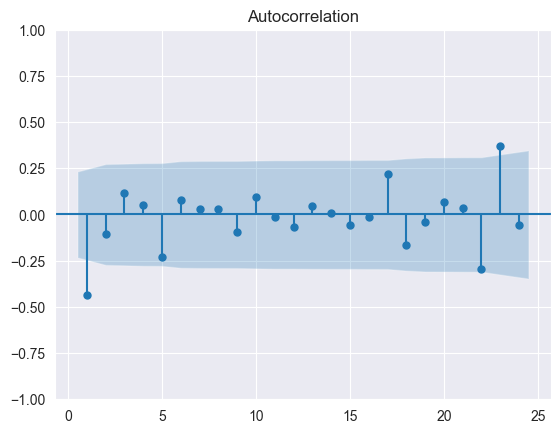

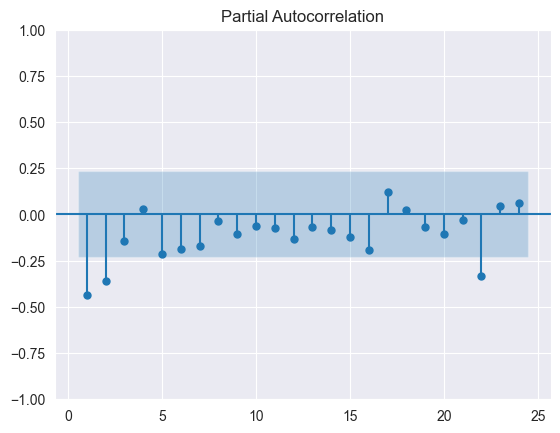

In [6]:
X_train["Sales_diff1_diff12"] = X_train["Sales"].diff(1).diff(12)

X_train.plot(subplots=True)
tsaplots.plot_acf(X_train["Sales_diff1_diff12"].dropna(), lags=24, zero=False)
tsaplots.plot_pacf(X_train["Sales_diff1_diff12"].dropna(), lags=24, zero=False)
plt.show()

In [7]:
adfuller(X_train["Sales_diff1_diff12"].dropna())[1]

1.106768501073039e-05

c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Gabriel\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   84
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -10.398
Date:                             Mon, 19 Feb 2024   AIC                             26.797
Time:                                     20:06:42   BIC                             33.585
Sample:                                 01-01-1998   HQIC                            29.496
                                      - 12-01-2004                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8166      0.074    -11.099      0.000      -0.961      -0.672
ar.S.L12      -0.3136      

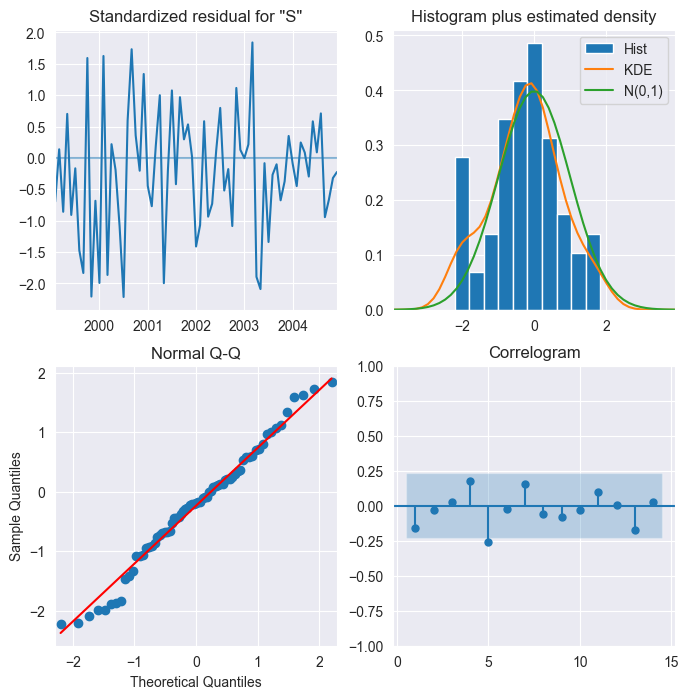

In [48]:
model_SARIMA = SARIMAX(np.log(X_train["Sales"]),order=(0,1,1),seasonal_order=(1,1,0,12), concentrate_scale= False).fit()
print(model_SARIMA.summary())
model_SARIMA.plot_diagnostics(lags=14, figsize=(8,8), acf_kwargs={"zero":False})
plt.show()

forecast_SARIMA = model_SARIMA.get_forecast(steps=12)

Holt-Winters RMSE:  37953.977235387356
SARIMA RMSE:  33727.77936657298


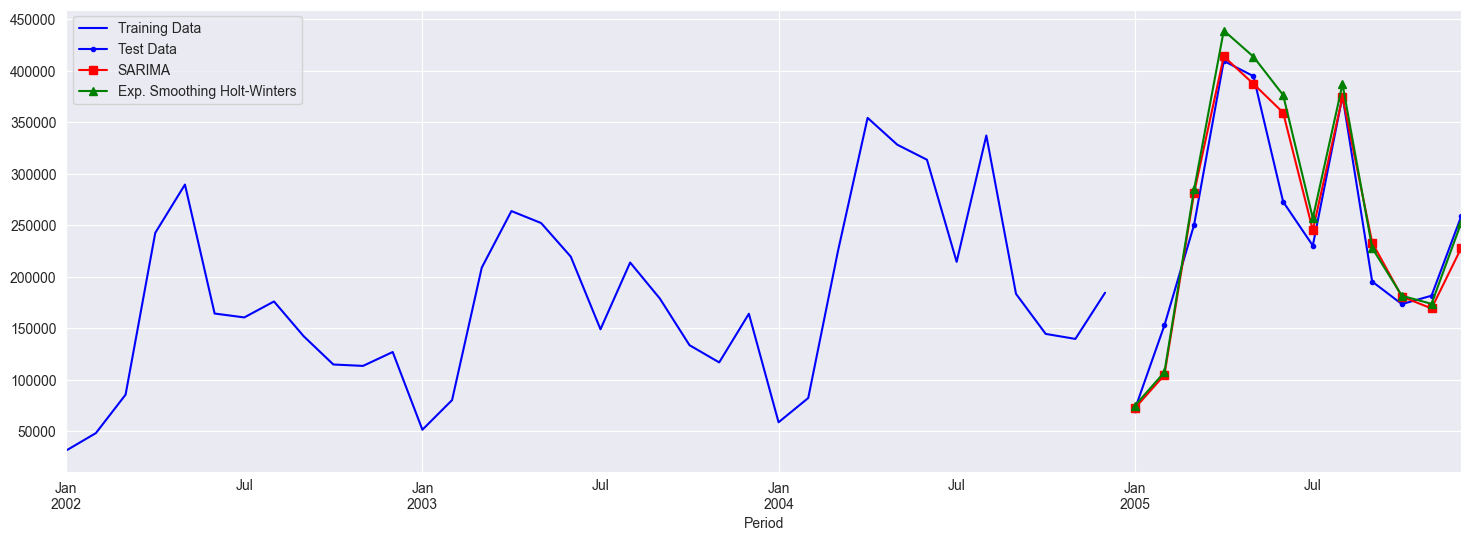

In [54]:
print("Holt-Winters RMSE: ",np.sqrt(mean_squared_error(X_test,forecast_holt_winters)))
print("SARIMA RMSE: ",np.sqrt(mean_squared_error(X_test,np.exp(forecast_SARIMA.predicted_mean))))

fig, ax=plt.subplots(1,1, figsize=(18,6))
X_train["Sales"].iloc[-36:].plot(ax=ax, label="Training Data", color="blue")
X_test["Sales"].plot(ax=ax, label = "Test Data",color="blue", marker=".")
np.exp(forecast_SARIMA.predicted_mean).plot(ax=ax, color="red", label="SARIMA", marker="s")
forecast_holt_winters.plot(ax=ax, color="green", label="Exp. Smoothing Holt-Winters", marker="^")
plt.legend()